In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tszip

import sys
sys.path.append("../sc2ts/")
import sc2ts.utils

### Compare the mutational spectrum in the ARGs with the mutational spectrum in "Mutational spectrum of SARS-CoV-2 during the global pandemic". https://www.nature.com/articles/s12276-021-00658-z


In [2]:
%%bash
if [ ! -d "./SC2_evol_signature/" ]; then
    git clone https://github.com/ju-lab/SC2_evol_signature.git
fi

In [3]:
csv_file = "./SC2_evol_signature/data/All_mutation_information.csv.gz"
dtypes = {
    'mutID': str,
    'type': str,
    'status 1': str,    # Ancestral node
    'status 2': str,    # Descendant node
    'position in refseq (one_based)': float,
    'position_in_msa0117_alignment (start)': float,
    'position_in_msa0117_alignment (end)': float,
    '(SBS) codon_position (0=noncoding, 1-3:position in triplet)': float,
    'base(s) in status 1': str,
    'base(s) in status 2': str,
    '(SBS) mutation in sequence context': str,
    '(SBS) gene': str,
    '(SBS) AA change': str,
    '(SBS) is coding': str,
    '(SBS) is nonsynonymous': str,
    '(SBS) is stopgain': str,
    '(MBS/Indel) with flaking sequences in status 1': str,
    '(MBS/Indel) with flaking sequences in status 2': str,
    '(Indel) ins or del': str,
    '(Indel) frame': str
}
df = pd.read_csv(csv_file, dtype=dtypes) # mixed dtypes because of doubly annotated entries
df

,mutID,type,status 1,status 2,position in refseq (one_based),position_in_msa0117_alignment (start),position_in_msa0117_alignment (end),"(SBS) codon_position (0=noncoding, 1-3:position in triplet)",base(s) in status 1,base(s) in status 2,(SBS) mutation in sequence context,(SBS) gene,(SBS) AA change,(SBS) is coding,(SBS) is nonsynonymous,(SBS) is stopgain,(MBS/Indel) with flaking sequences in status 1,(MBS/Indel) with flaking sequences in status 2,(Indel) ins or del,(Indel) frame
0,sbs_10_TT>GT_633183_329639,SBS,node281658,hCoV-19/USA/LA-EVTL071/2020|EPI_ISL_451232|202...,10.0,122.0,122.0,0.0,T,G,TT>GT,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN
1,sbs_11_TT>CA_357288_6016,SBS,node5763,hCoV-19/USA/UT-UPHL-2012146142/2020|EPI_ISL_74...,11.0,123.0,123.0,0.0,T,C,TT>CA,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN
2,sbs_13_AT>AA_649653_348274,SBS,node298128,hCoV-19/USA/CA-CSMC203/2020|EPI_ISL_824612|202...,13.0,125.0,125.0,0.0,T,A,AT>AA,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN
3,sbs_13_AT>CA_631201_327314,SBS,node279676,hCoV-19/USA/LA-EVTL1196/2020|EPI_ISL_768465|20...,13.0,125.0,125.0,0.0,T,C,AT>CA,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN
4,sbs_13_AT>CA_611678_611679,SBS,node260153,node260154,13.0,125.0,125.0,0.0,T,C,AT>CA,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284734,ind_29870_->c_529146_529147,Indel,node177621,node177622,29870.0,31970.0,31970.0,NaN,-,c,NaN,NaN,NaN,NaN,NaN,NaN,TGTGATTTTAATAGCTTCTTAGGAGAATGA-AAAAAAAAAAAA---...,TGTGATTTTAATAGCTTCTTAGGAGAATGAcAAAAAAAAAAAA---...,others,frameshift
284735,ind_29870_->A_474950_474951,Indel,node123425,node123426,29870.0,31970.0,31970.0,NaN,-,A,NaN,NaN,NaN,NaN,NaN,NaN,TGTGATTTTAATAGCTTCTTAGGAGAATGA-AAAAAAAAAAAAAAA...,TGTGATTTTAATAGCTTCTTAGGAGAATGAAAAAAAAAAAAAAAAA...,insertion,frameshift
284736,ind_29870_->C_474957_146641,Indel,node123432,hCoV-19/Malaysia/2101/2020|EPI_ISL_501191|2020...,29870.0,31970.0,31970.0,NaN,-,C,NaN,NaN,NaN,NaN,NaN,NaN,TGTGATTTTAATAGCTTCTTAGGAGAATGA-AAAAAAAAAAAAAAA...,TGTGATTTTAATAGCTTCTTAGGAGAATGACAAAAAAAAAAAAAAA...,insertion,frameshift
284737,ind_29870_->A_474948_474965,Indel,node123423,node123440,29870.0,31970.0,31970.0,NaN,-,A,NaN,NaN,NaN,NaN,NaN,NaN,TGTGATTTTAATAGCTTCTTAGGAGAATGA-AAAAAAAAAAAAAAA...,TGTGATTTTAATAGCTTCTTAGGAGAATGAAAAAAAAAAAAAAAAA...,insertion,frameshift


In [4]:
# SBS = single base substitution
# MBS = multiple base substitution
# Note that the positions are 1-based.
df["type"].value_counts()

SBS      277639
Indel      6001
MBS        1099
Name: type, dtype: int64

In [5]:
# Taken from ./sc2ts/utils.py and modified.
def plot_mutation_spectrum(counter, show_percentage=False):
    if show_percentage:
        total_count = sum(counter.values())
        counter = {k: (v / total_count) * 100 for k, v in counter.items()}

    fig, ax = plt.subplots(1, 1)
    types = ["C>T", "G>A", "G>T", "G>C", "C>A", "T>A"]
    rev_types = [t[::-1] for t in types]
    x = range(len(types))
    ax.bar(x, [counter[t] for t in types])
    ax.bar(x, [-counter[t] for t in rev_types], bottom=0)

    ax2 = ax.secondary_xaxis("top")
    ax2.tick_params(axis="x")
    ax2.set_xticks(x)

    ax2.set_xticklabels(types)
    ax.set_xticks(x)
    ax.set_xticklabels(rev_types)

    y = max(counter.values())
    step = y / 10
    for key in ["C>T", "G>T"]:
        rev_key = key[::-1]
        ratio = counter[key] / counter[rev_key]
        text = f"{key} / {rev_key}={ratio:.2f}"
        y -= step
        ax.text(3.5, y, text)

In [6]:
# All SBS-type mutations
df_sbs = df[df["type"] == "SBS"]
df_sbs.reset_index()

df_sbs = df_sbs.assign(mutation = df_sbs["base(s) in status 1"] + ">" + df_sbs["base(s) in status 2"])
df_sbs

,mutID,type,status 1,status 2,position in refseq (one_based),position_in_msa0117_alignment (start),position_in_msa0117_alignment (end),"(SBS) codon_position (0=noncoding, 1-3:position in triplet)",base(s) in status 1,base(s) in status 2,...,(SBS) gene,(SBS) AA change,(SBS) is coding,(SBS) is nonsynonymous,(SBS) is stopgain,(MBS/Indel) with flaking sequences in status 1,(MBS/Indel) with flaking sequences in status 2,(Indel) ins or del,(Indel) frame,mutation
0,sbs_10_TT>GT_633183_329639,SBS,node281658,hCoV-19/USA/LA-EVTL071/2020|EPI_ISL_451232|202...,10.0,122.0,122.0,0.0,T,G,...,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,T>G
1,sbs_11_TT>CA_357288_6016,SBS,node5763,hCoV-19/USA/UT-UPHL-2012146142/2020|EPI_ISL_74...,11.0,123.0,123.0,0.0,T,C,...,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,T>C
2,sbs_13_AT>AA_649653_348274,SBS,node298128,hCoV-19/USA/CA-CSMC203/2020|EPI_ISL_824612|202...,13.0,125.0,125.0,0.0,T,A,...,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,T>A
3,sbs_13_AT>CA_631201_327314,SBS,node279676,hCoV-19/USA/LA-EVTL1196/2020|EPI_ISL_768465|20...,13.0,125.0,125.0,0.0,T,C,...,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,T>C
4,sbs_13_AT>CA_611678_611679,SBS,node260153,node260154,13.0,125.0,125.0,0.0,T,C,...,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,T>C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277634,sbs_29878_AA>CA_478402_150327,SBS,node126877,hCoV-19/Guangzhou/GZMU0079/2020|EPI_ISL_457691...,29878.0,31978.0,31978.0,0.0,A,C,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A>C
277635,sbs_29879_AA>TA_615119_310312,SBS,node263594,hCoV-19/USA/HI-H200101/2020|EPI_ISL_752665|202...,29879.0,31979.0,31979.0,0.0,A,T,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A>T
277636,sbs_29881_AA>CA_611660_306625,SBS,node260135,hCoV-19/USA/WA-UW-11630/2020|EPI_ISL_570449|20...,29881.0,31981.0,31981.0,0.0,A,C,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A>C
277637,sbs_29886_AA>GA_372890_23465,SBS,node21365,hCoV-19/England/OXON-B3FC3/2020|EPI_ISL_534921...,29886.0,31986.0,31986.0,0.0,A,G,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A>G


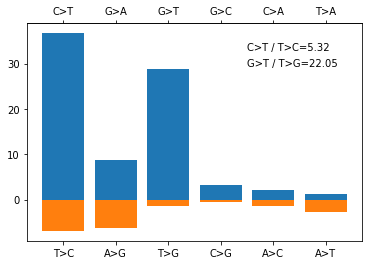

In [7]:
# Non-coding mutations
df_nc = df_sbs[df_sbs["(SBS) codon_position (0=noncoding, 1-3:position in triplet)"] == 0]
df_nc.reset_index()

plot_mutation_spectrum(Counter(df_nc["mutation"]), show_percentage=True)

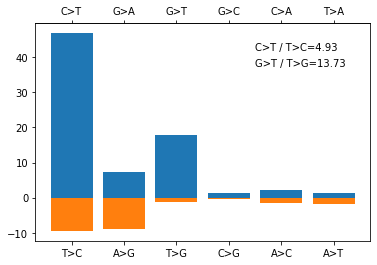

In [8]:
# Coding mutations
df_cd = df_sbs[df_sbs["(SBS) codon_position (0=noncoding, 1-3:position in triplet)"] > 0]
df_cd.reset_index()

plot_mutation_spectrum(Counter(df_cd["mutation"]), show_percentage=True)

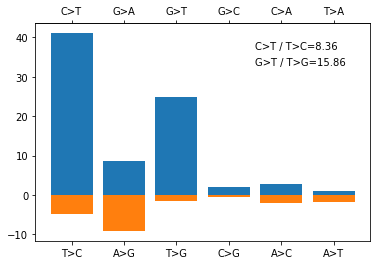

In [9]:
# Non-synonymous coding mutations
df_ns = df_cd[(df_cd["(SBS) is nonsynonymous"] == "TRUE") |
              (df_cd["(SBS) is nonsynonymous"] == "TRUE, TRUE")]
df_ns.reset_index()

plot_mutation_spectrum(Counter(df_ns["mutation"]), show_percentage=True)

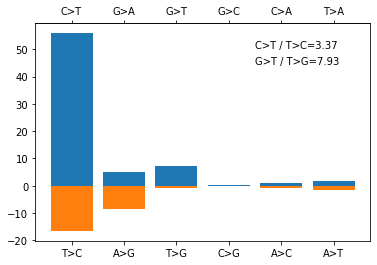

In [10]:
# Synonymous coding mutations
df_syn = df_cd[(df_cd["(SBS) is nonsynonymous"] == "FALSE") |
               (df_cd["(SBS) is nonsynonymous"] == "FALSE, FALSE")]
df_syn.reset_index()

plot_mutation_spectrum(Counter(df_syn["mutation"]), show_percentage=True)

In [11]:
def plot_juxtaposed_mutation_spectra(counter1, counter2, labels, show_percentage=False, show_uracil=False, show_ratios=True):
    assert len(labels) == 2

    if show_percentage:
        def _convert_to_percentages(counter):
            # Skip entries involving gaps
            total_count = sum([v for k, v in counter.items() if "-" not in k])
            counter = {k: (v / total_count) * 100 for k, v in counter.items()}
            return(counter)
        counter1 = _convert_to_percentages(counter1)
        counter2 = _convert_to_percentages(counter2)

    width = 0.4 # bar width
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 8)
    ax.tick_params(axis='both', which='major', labelsize=16)
    types = ["C>T", "G>A", "G>T", "G>C", "C>A", "T>A"]
    rev_types = [t[::-1] for t in types]
    x = np.arange(len(types))
    if show_percentage:
        ax.set_ylabel("Percentage", fontsize=20)
    else:
        ax.set_ylabel("Number of events", fontsize=20)
    ax.bar(x, [counter1[t] for t in types], width=width, color="royalblue")
    ax.bar(x, [-counter1[t] for t in rev_types], width=width, color="lightsteelblue", bottom=0)
    ax.bar(x + width, [counter2[t] for t in types], width=width, color="orange")
    ax.bar(x + width, [-counter2[t] for t in rev_types], width=width, color="moccasin", bottom=0)

    ax2 = ax.secondary_xaxis("top")
    ax2.tick_params(axis="x")
    ax2.set_xticks(x + width / 2)

    def _replace_T_with_U(s): return(s.replace("T", "U"))
    if show_uracil:
        types = [_replace_T_with_U(t) for t in types]
        rev_types = [_replace_T_with_U(t) for t in rev_types]
    ax2.set_xticklabels(types, fontsize=20)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(rev_types, fontsize=20)

    ax.legend(
        [labels[0], labels[0], labels[1], labels[1]],
        loc="best",
        frameon=False,
        fontsize=14
    )

    if show_ratios:
        y = max(max(counter1.values()), max(counter2.values())) / 2
        step = y / 10
        for key in ["C>T", "G>T"]:
            rev_key = key[::-1]
            ratio1 = counter1[key] / counter1[rev_key]
            ratio2 = counter2[key] / counter2[rev_key]
            if show_uracil:
                key = _replace_T_with_U(key)
                rev_key = _replace_T_with_U(rev_key)
            text1 = f"{key} / {rev_key}={ratio1:.2f}"
            text2 = f"{key} / {rev_key}={ratio2:.2f}"
            y -= step
            ax.text(3.5, y, text1, fontsize=14)
            y -= step
            ax.text(3.5, y, text2, fontsize=14)

    return(fig)


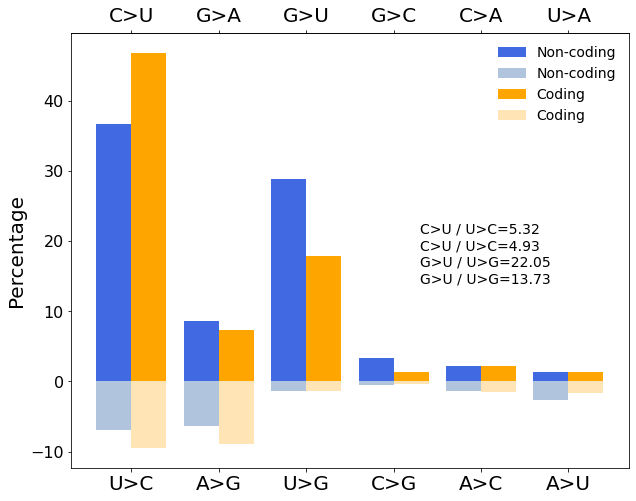

In [12]:
# Compare the spectra of non-coding mutations and coding mutations
figure = plot_juxtaposed_mutation_spectra(
    Counter(df_nc["mutation"]), Counter(df_cd["mutation"]),
    labels=["Non-coding", "Coding"],
    show_percentage=True,
    show_uracil=True,
    show_ratios=True
)

In [13]:
ts = tszip.decompress("../sars2_recomb/data/upgma-full-md-30-mm-3-2021-06-30-recinfo-il.ts.tsz")
ti = sc2ts.utils.TreeInfo(ts)

# Inheritors are terminal samples inheriting a mutation, not internal samples.
muts_ti_mi_1 = ti.get_mutation_spectrum(min_inheritors=1)
muts_ti_mi_2 = ti.get_mutation_spectrum(min_inheritors=2)

Classifying mutations: 100%|██████████| 1213193/1213193 [00:17<00:00, 67591.88it/s]


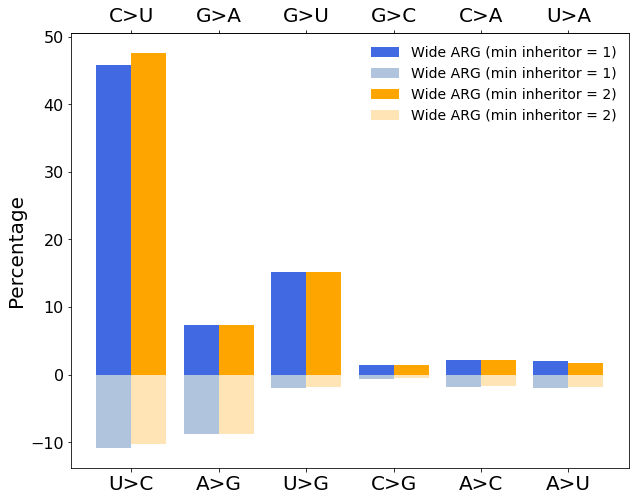

In [14]:
# Compare the spectrum including mutations with only one inheritor in the wide ARG and that excluding them.
figure = plot_juxtaposed_mutation_spectra(
    muts_ti_mi_1, muts_ti_mi_2,
    labels=["Wide ARG (min inheritor = 1)", "Wide ARG (min inheritor = 2)"],
    show_percentage=True,
    show_uracil=True,
    show_ratios=False
)

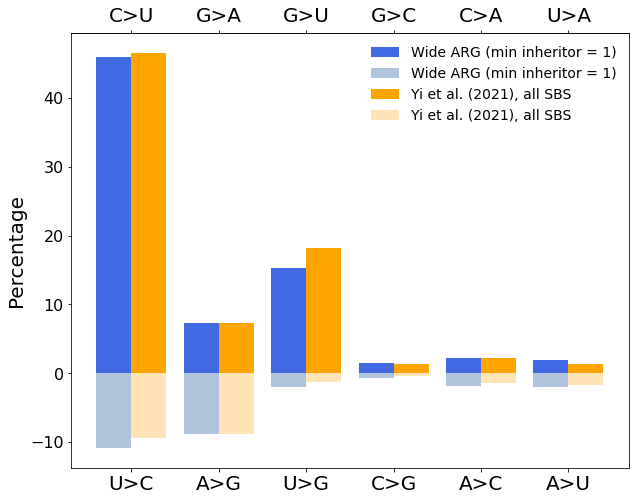

In [15]:
# Compare the spectrum in the wide ARG (min_inheritors = 1) and that from the paper (all SBS).
figure = plot_juxtaposed_mutation_spectra(
    muts_ti_mi_1, Counter(df_sbs["mutation"]),
    labels=["Wide ARG (min inheritor = 1)", "Yi et al. (2021), all SBS"],
    show_percentage=True,
    show_uracil=True,
    show_ratios=False
)

In [16]:
# Exclude mutations ocurring on terminal branches in the phylogeny from Yi et al.
df_shared_sbs = df_sbs[df_sbs["status 2"].str.contains('^node', case=True)]
df_shared_sbs.reset_index()

,index,mutID,type,status 1,status 2,position in refseq (one_based),position_in_msa0117_alignment (start),position_in_msa0117_alignment (end),"(SBS) codon_position (0=noncoding, 1-3:position in triplet)",base(s) in status 1,...,(SBS) gene,(SBS) AA change,(SBS) is coding,(SBS) is nonsynonymous,(SBS) is stopgain,(MBS/Indel) with flaking sequences in status 1,(MBS/Indel) with flaking sequences in status 2,(Indel) ins or del,(Indel) frame,mutation
0,4,sbs_13_AT>CA_611678_611679,SBS,node260153,node260154,13.0,125.0,125.0,0.0,T,...,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,T>C
1,22,sbs_21_CC>TA_593594_593595,SBS,node242069,node242070,21.0,133.0,133.0,0.0,C,...,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,C>T
2,41,sbs_27_AA>CC_352872_352875,SBS,node1347,node1350,27.0,139.0,139.0,0.0,A,...,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A>C
3,42,sbs_27_AA>CC_469615_469616,SBS,node118090,node118091,27.0,139.0,139.0,0.0,A,...,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A>C
4,46,sbs_28_AC>TA_552713_552714,SBS,node201188,node201189,28.0,140.0,140.0,0.0,C,...,5'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,C>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92339,277614,sbs_29870_AA>CA_415789_415793,SBS,node64264,node64268,29870.0,31970.0,31970.0,0.0,A,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A>C
92340,277615,sbs_29870_AC>AA_438569_438570,SBS,node87044,node87045,29870.0,31970.0,31970.0,0.0,C,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,C>A
92341,277619,sbs_29870_AA>CA_482679_482680,SBS,node131154,node131155,29870.0,31970.0,31970.0,0.0,A,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A>C
92342,277621,sbs_29870_AA>CA_481640_481641,SBS,node130115,node130116,29870.0,31970.0,31970.0,0.0,A,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A>C


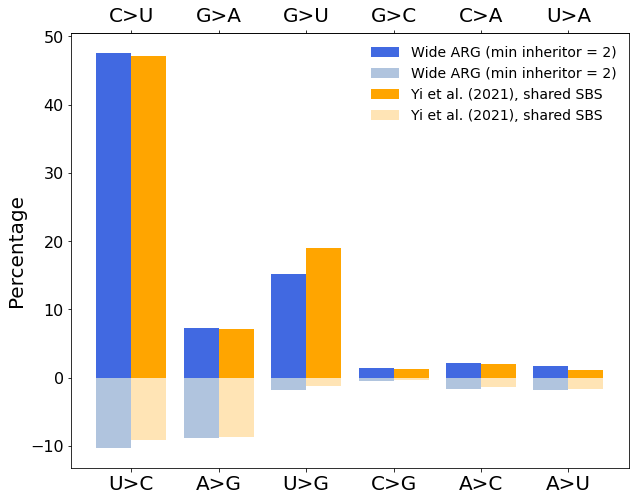

In [17]:
# Compare the spectrum in the wide ARG (min_inheritors = 2) and that from the paper (shared SBS).
# Note that there are differences when excluding mutations in the ARG and the tree from the paper.
# In the ARG, samples are represented by internal nodes or terminal nodes; however,
# in the tree of Yi et al., all the samples are represented by terminal nodes.
figure = plot_juxtaposed_mutation_spectra(
    muts_ti_mi_2, Counter(df_shared_sbs["mutation"]),
    labels = ["Wide ARG (min inheritor = 2)", "Yi et al. (2021), shared SBS"],
    show_percentage=True,
    show_uracil=True,
    show_ratios=False
)